In [9]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, Predictive
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

## 1. Initial Processing

In [2]:
# Set your own path
path = 'data/CA_final.csv'

df = pd.read_csv(path)
df.head()

KeyboardInterrupt: 

In [4]:
len(df)

1741433

We've got 1.7M accident records in CA.

In [5]:
df.groupby('Year')['ID'].size()

Year
2016    140452
2017    152748
2018    156898
2019    213455
2020    285532
2021    341876
2022    375913
2023     74559
Name: ID, dtype: int64

In [7]:
df_2022 = df[df['Year'] == 2022]
df_2022.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Hour,Minute,Wind_Speed(mph)_Imputed,Humidity(%)_Imputed,Temperature(F)_Imputed,Visibility(mi)_Imputed,Pressure(in)_Imputed,geohash4,Wind_Direction_Imputed,Weather_Condition_Imputed
175167,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.0,...,2,2,6.0,28.0,86.0,10.0,27.35,9qhh,E,Thunderstorms and Rain
175168,A-512257,Source2,1,2022-09-08 02:02:58,2022-09-08 02:32:20,34.177322,-118.877014,NaN,NaN,0.0,...,2,2,3.0,87.0,68.0,9.0,29.78,9q56,WNW,Thunderstorms and Rain
175169,A-512277,Source2,3,2022-09-07 21:54:19,2022-09-07 22:38:20,38.593945,-121.504059,NaN,NaN,0.0,...,21,54,0.0,28.0,83.0,10.0,29.83,9qce,VAR,Thunderstorms and Rain
175170,A-512340,Source2,2,2022-09-08 02:03:43,2022-09-08 02:33:13,33.850147,-117.875938,NaN,NaN,0.0,...,2,3,0.0,66.0,79.0,10.0,29.76,9qh0,VAR,Thunderstorms and Rain
175171,A-512341,Source3,1,2022-09-08 02:30:59,2022-09-08 03:00:27,33.884056,-118.029007,NaN,NaN,0.0,...,2,30,0.0,66.0,78.0,10.0,29.74,9qh0,VAR,Thunderstorms and Rain


In [8]:
df_2022['Start_Time'].min(), df_2022['Start_Time'].max()

('2022-01-01 00:02:00', '2022-12-31 23:59:00')

In [11]:
# Saving data for 2022 to lighten memory.
save_path = 'data/data_2022.csv'
df_2022.to_csv(save_path)

If you have already saved data for 2022 start here

In [3]:
# Load 2022 data
load_path = 'data/data_2022.csv'
df = pd.read_csv(load_path)

In [4]:
len(df)

375913

In [16]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

In [5]:
# Creating a time range with index representing consecutive hours in 2022
start_time = pd.Timestamp('2022-01-01 00:00:00')
end_time = pd.Timestamp('2022-12-31 23:00:00')
hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')
hourly_df = pd.DataFrame(hourly_range, columns=['hour'])
hourly_df['hour_index'] = range(1, len(hourly_range) + 1)


C:\Users\balda\AppData\Local\Temp\ipykernel_20292\2312101316.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')


In [6]:
hourly_df.head()

,hour,hour_index
0,2022-01-01 00:00:00,1
1,2022-01-01 01:00:00,2
2,2022-01-01 02:00:00,3
3,2022-01-01 03:00:00,4
4,2022-01-01 04:00:00,5


In [24]:
len(hourly_df)

8760

In [7]:
geohashes = df['geohash5'].unique()
multi_index = pd.MultiIndex.from_product([hourly_range, geohashes], names=['hour', 'geohash5'])
multi_index_df = pd.DataFrame(index=multi_index).reset_index()

In [8]:
multi_index_df.head()

,hour,geohash5
0,2022-01-01,9qhh7
1,2022-01-01,9q56q
2,2022-01-01,9qcee
3,2022-01-01,9qh0t
4,2022-01-01,9qh0f


In [57]:
# Step 6: Count accidents per hour and geohash
accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')

# Step 7: Merge the multi-index DataFrame with the accident counts
merged_df = pd.merge(multi_index_df, accident_counts, how='left', left_on=['hour', 'geohash5'], right_on=['Start_Time', 'geohash5'])

C:\Users\balda\AppData\Local\Temp\ipykernel_20292\3631858385.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')


Let's add one_hot_encoded features for hour of the day and day of the week.

In [58]:
merged_df = merged_df.drop(columns=['Start_Time']).fillna(value=0)

# Assuming 'df' is your DataFrame with the structure you provided
# If not already in datetime format, ensure 'hour' is in datetime format
merged_df['hour'] = pd.to_datetime(merged_df['hour'])

# Step 1: Extract hour of the day and day of the week
merged_df['hour_of_day'] = merged_df['hour'].dt.hour
merged_df['day_of_week'] = merged_df['hour'].dt.dayofweek  # Monday=0, Sunday=6

# Step 2: Generate one-hot encoded columns
hour_dummies = pd.get_dummies(merged_df['hour_of_day'], prefix='hour')
day_dummies = pd.get_dummies(merged_df['day_of_week'], prefix='day')

# Step 3: Concatenate these new columns to the original DataFrame
merged_df = pd.concat([merged_df, hour_dummies, day_dummies], axis=1)

# Display the final DataFrame
print(merged_df)

                        hour geohash5  accident_count  hour_of_day  \
0        2022-01-01 00:00:00    9qhh7             0.0            0   
1        2022-01-01 00:00:00    9q56q             1.0            0   
2        2022-01-01 00:00:00    9qcee             0.0            0   
3        2022-01-01 00:00:00    9qh0t             0.0            0   
4        2022-01-01 00:00:00    9qh0f             0.0            0   
...                      ...      ...             ...          ...   
63448675 2022-12-31 23:00:00    9r4rr             0.0           23   
63448676 2022-12-31 23:00:00    9r354             0.0           23   
63448677 2022-12-31 23:00:00    9r3q8             0.0           23   
63448678 2022-12-31 23:00:00    9r4n7             0.0           23   
63448679 2022-12-31 23:00:00    9r0wf             0.0           23   

          day_of_week  hour_0  hour_1  hour_2  hour_3  hour_4  ...  hour_21  \
0                   5    True   False   False   False   False  ...    False   
1

There's a lot of hashes and a lot of hours so let's take just one hash for now and try to model it. Going for hash `9q5cw` - one with the most accidents in 2022.

In [180]:
merged_df.to_csv('data/merged_df.csv')

In [2]:
merged_df = pd.read_csv('data/merged_df.csv', index_col=[0])

In [11]:
hash_list = ['9mudn', '9q5bs', '9q5by', '9q5c4', '9q5ch', 
             '9q5cj', '9q5ck', '9q5cs', '9q5ct', '9q5cv', 
             '9q5cw', '9q5f2', '9q9nm', '9qh10', '9qh93']

weather_columns = ['datetime', 'wind_speed', 'height_above_ground_level', 'visibility', 'temperature', 'dew_point']

hash_df_dict = {}

for hash in hash_list:

    print(f'Processing: {hash}')

    # Filter merged_df to one hash
    hash_df = merged_df[merged_df['geohash5'] == hash]

    # For some weird reason
    hash_df.loc[hash_df['hour'] == '2022-01-01', 'hour'] = '2022-01-01 00:00:00'

    # Create lags
    hash_df['accident_count_lag1'] = hash_df['accident_count'].shift(1)
    hash_df['accident_count_lag2'] = hash_df['accident_count'].shift(2)
    hash_df['accident_count_lag3'] = hash_df['accident_count'].shift(3)
    hash_df['accident_count_lag4'] = hash_df['accident_count'].shift(4)
    hash_df['accident_count_lag5'] = hash_df['accident_count'].shift(5)
    hash_df['accident_count_lag6'] = hash_df['accident_count'].shift(6)
    hash_df['accident_count_lag7'] = hash_df['accident_count'].shift(7)

    print(hash,'- ', len(hash_df[hash_df['accident_count'] > 0]) / len(hash_df) * 100, '% of hourly observations had accident\n')

    # Load weather df
    hash_weather_df = pd.read_csv(f'data/final_{hash}.csv')[weather_columns]

    # Merge weather with hash_df
    merged_hash_df = pd.merge(hash_df, hash_weather_df, left_on='hour', right_on='datetime', how='left').drop(columns=['datetime'])

    # Add to dict
    hash_df_dict[hash] = merged_hash_df

Processing: 9mudn
9mudn -  10.536529680365298 % of hourly observations had accident

Processing: 9q5bs
9q5bs -  10.479452054794521 % of hourly observations had accident

Processing: 9q5by
9q5by -  11.164383561643836 % of hourly observations had accident

Processing: 9q5c4
9q5c4 -  10.102739726027398 % of hourly observations had accident

Processing: 9q5ch
9q5ch -  14.132420091324201 % of hourly observations had accident

Processing: 9q5cj
9q5cj -  10.547945205479452 % of hourly observations had accident

Processing: 9q5ck
9q5ck -  8.310502283105023 % of hourly observations had accident

Processing: 9q5cs
9q5cs -  17.534246575342465 % of hourly observations had accident

Processing: 9q5ct
9q5ct -  19.200913242009133 % of hourly observations had accident

Processing: 9q5cv
9q5cv -  14.28082191780822 % of hourly observations had accident

Processing: 9q5cw
9q5cw -  21.335616438356166 % of hourly observations had accident

Processing: 9q5f2
9q5f2 -  10.867579908675799 % of hourly observati

In [28]:
for hash, df in hash_df_dict.items():
    print(hash, min(df.dropna()['hour']), max(df.dropna()['hour']), len(df.dropna()))

9mudn 2022-01-01 07:00:00 2022-12-31 23:00:00 8741
9q5bs 2022-01-01 07:00:00 2022-12-31 23:00:00 8733
9q5by 2022-01-01 07:00:00 2022-12-31 23:00:00 8751
9q5c4 2022-01-01 07:00:00 2022-12-31 23:00:00 8749
9q5ch 2022-01-01 07:00:00 2022-12-31 23:00:00 8713
9q5cj 2022-01-01 07:00:00 2022-12-31 23:00:00 8740
9q5ck 2022-01-01 07:00:00 2022-12-31 23:00:00 8723
9q5cs 2022-01-01 07:00:00 2022-12-31 23:00:00 8748
9q5ct 2022-01-01 07:00:00 2022-12-31 23:00:00 8743
9q5cv 2022-01-01 07:00:00 2022-12-31 23:00:00 8741
9q5cw 2022-01-01 07:00:00 2022-12-31 23:00:00 8737
9q5f2 2022-01-01 07:00:00 2022-12-31 23:00:00 8741
9q9nm 2022-01-01 07:00:00 2022-12-31 23:00:00 8724
9qh10 2022-01-01 07:00:00 2022-12-31 23:00:00 8751
9qh93 2022-01-01 07:00:00 2022-12-31 23:00:00 8714


## 2. Training

In [26]:
# Features list (can be any hash as all have same schema)
features = hash_df.drop(columns=['hour', 'geohash5', 'accident_count', 'hour_of_day', 'day_of_week']).columns

# Training and testing sets dictionary
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for hash, hash_df in hash_df_dict.items():

    print(f'Processing {hash}')

    print(len(hash_df))

    # Drop first observations with no available lags
    hash_df = hash_df.dropna()

    print(len(hash_df))

    # Define target
    y = np.array(hash_df['accident_count'], dtype=np.float16)
    X = np.array(hash_df[features], dtype=np.float16)

    # Split into train and test
    N = len(X)
    split_idx = int(0.85*N)
    X_train = X[:split_idx,:]
    y_train = y[:split_idx]
    X_test = X[split_idx:,:]
    y_test = y[split_idx:]

    print(' X_train:', X_train.shape, '\n', 'X_test:', X_test.shape, '\n', 'y_train:', y_train.shape, '\n', 'y_test:', y_test.shape, '\n')

    # Standardize input features
    X_train_mean = X_train.mean(axis=0)
    X_test_mean = X_test.mean(axis=0)

    X_train_std = X_train.std(axis=0)
    X_test_std = X_test.std(axis=0)

    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_test_mean) / X_test_std

    # Prepare data for Pyro model
    X_train_torch = torch.tensor(X_train).float()
    y_train_torch = torch.tensor(y_train).float()

    # Save to dict
    X_train_dict[hash] = X_train_torch
    X_test_dict[hash] = X_test
    y_train_dict[hash] = y_train_torch
    y_test_dict[hash] = y_test

Processing 9mudn
8760
8741
 X_train: (7429, 43) 
 X_test: (1312, 43) 
 y_train: (7429,) 
 y_test: (1312,) 

Processing 9q5bs
8760
8733
 X_train: (7423, 43) 
 X_test: (1310, 43) 
 y_train: (7423,) 
 y_test: (1310,) 

Processing 9q5by
8760
8751
 X_train: (7438, 43) 
 X_test: (1313, 43) 
 y_train: (7438,) 
 y_test: (1313,) 



c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Processing 9q5c4
8760
8749
 X_train: (7436, 43) 
 X_test: (1313, 43) 
 y_train: (7436,) 
 y_test: (1313,) 

Processing 9q5ch
8760
8713
 X_train: (7406, 43) 
 X_test: (1307, 43) 
 y_train: (7406,) 
 y_test: (1307,) 

Processing 9q5cj
8760
8740
 X_train: (7429, 43) 
 X_test: (1311, 43) 
 y_train: (7429,) 
 y_test: (1311,) 

Processing 9q5ck
8760
8723
 X_train: (7414, 43) 
 X_test: (1309, 43) 
 y_train: (7414,) 
 y_test: (1309,) 

Processing 9q5cs
8760
8748
 X_train: (7435, 43) 
 X_test: (1313, 43) 
 y_train: (7435,) 
 y_test: (1313,) 

Processing 9q5ct
8760
8743
 X_train: (7431, 43) 
 X_test: (1312, 43) 
 y_train: (7431,) 
 y_test: (1312,) 

Processing 9q5cv
8760
8741
 X_train: (7429, 43) 
 X_test: (1312, 43) 
 y_train: (7429,) 
 y_test: (1312,) 

Processing 9q5cw
8760
8737
 X_train: (7426, 43) 
 X_test: (1311, 43) 
 y_train: (7426,) 
 y_test: (1311,) 

Processing 9q5f2
8760
8741
 X_train: (7429, 43) 
 X_test: (1312, 43) 
 y_train: (7429,) 
 y_test: (1312,) 

Processing 9q9nm
8760
8724
 

In [121]:
# Drop first observations with no available lags
merged_weather_df = merged_weather_df.dropna()

# Features
features = merged_weather_df.drop(columns=['hour', 'geohash5', 'accident_count', 'hour_of_day', 'day_of_week']).columns

# Define target
y = np.array(merged_weather_df['accident_count'], dtype=np.float16)
X = np.array(merged_weather_df[features], dtype=np.float16)

# Split into train and test
N = len(X)
split_idx = int(0.85*N)
X_train = X[:split_idx,:]
y_train = y[:split_idx]
X_test = X[split_idx:,:]
y_test = y[split_idx:]

print(' X_train:', X_train.shape, '\n', 'X_test:', X_test.shape, '\n', 'y_train:', y_train.shape, '\n', 'y_test:', y_test.shape)

 X_train: (7426, 43) 
 X_test: (1311, 43) 
 y_train: (7426,) 
 y_test: (1311,)


In [122]:
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_test_mean = X_test.mean(axis=0)

X_train_std = X_train.std(axis=0)
X_test_std = X_test.std(axis=0)

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_test_mean) / X_test_std

c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [123]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [124]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [125]:
def poisson_model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1]) * 0.25).to_event())    # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Poisson(torch.exp(alpha + X.matmul(beta))), obs=obs)
        
    return y

In [126]:
# Define guide function
guide = AutoDiagonalNormal(poisson_model)

# Reset parameter values
pyro.clear_param_store()

In [127]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(poisson_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 10792.3
[500] ELBO: 7519.1
[1000] ELBO: 6639.5
[1500] ELBO: 6595.0
[2000] ELBO: 6575.2
[2500] ELBO: 6559.0
[3000] ELBO: 6549.4
[3500] ELBO: 6550.6
[4000] ELBO: 6545.9
[4500] ELBO: 6538.9
[5000] ELBO: 6536.1
[5500] ELBO: 6537.8
[6000] ELBO: 6535.8
[6500] ELBO: 6538.2
[7000] ELBO: 6536.1
[7500] ELBO: 6537.5
[8000] ELBO: 6533.1
[8500] ELBO: 6534.4
[9000] ELBO: 6538.8
[9500] ELBO: 6537.8


In [128]:
predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [129]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()

y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T)), axis=1)

preds = y_hat 

corr, mae, rae, rmse, r2 = compute_error(y_test, preds)

print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.220
MAE: 0.579
RMSE: 0.887
R2: 0.045


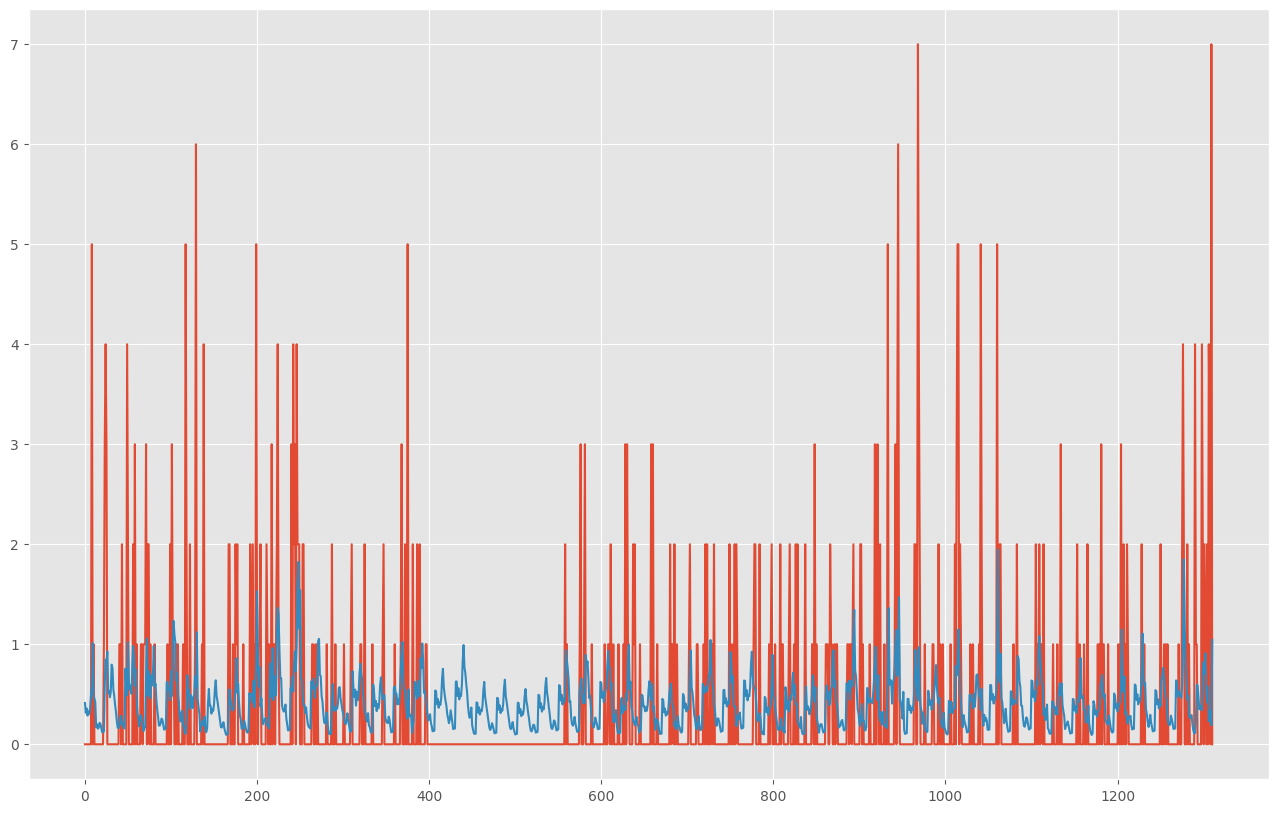

In [130]:
plt.plot(y_test)
plt.plot(preds)

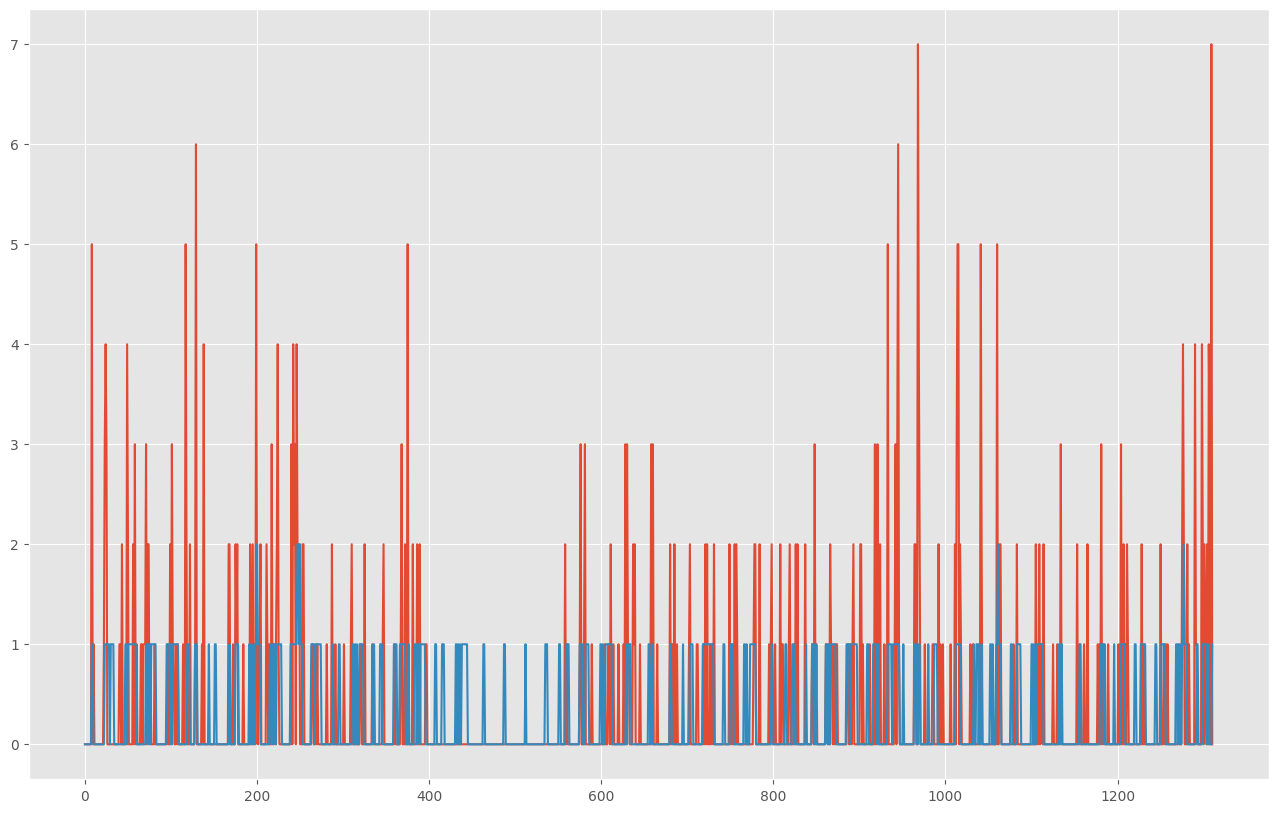

In [131]:
plt.plot(y_test)
plt.plot(np.round(preds, decimals=0))

(array([  2., 270., 825., 118.,  61.,  17.,  11.,   5.,   0.,   2.]),
 array([-2.        , -1.10000002, -0.2       ,  0.69999999,  1.60000002,
         2.5       ,  3.4000001 ,  4.30000019,  5.19999981,  6.0999999 ,
         7.        ]),
 <BarContainer object of 10 artists>)

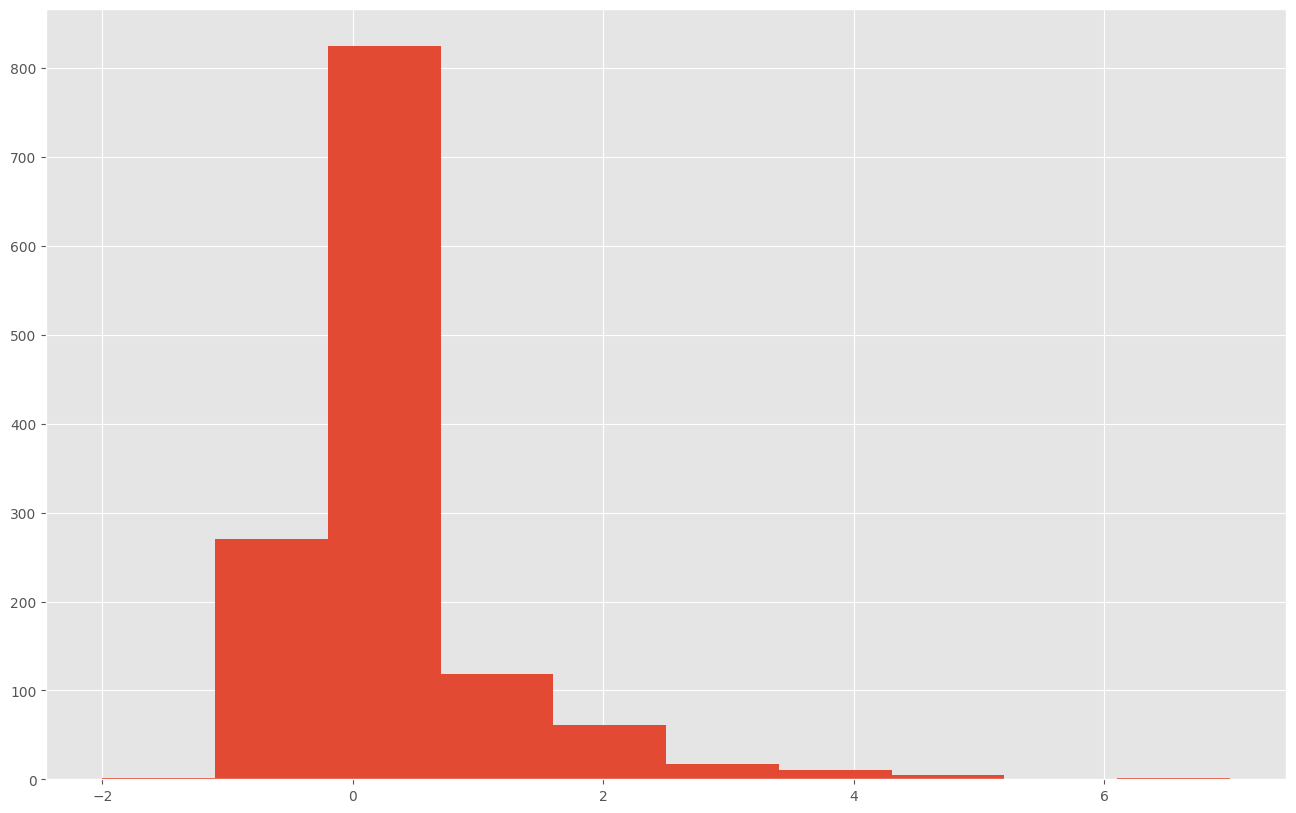

In [132]:
plt.hist(y_test - np.round(preds, decimals=0))

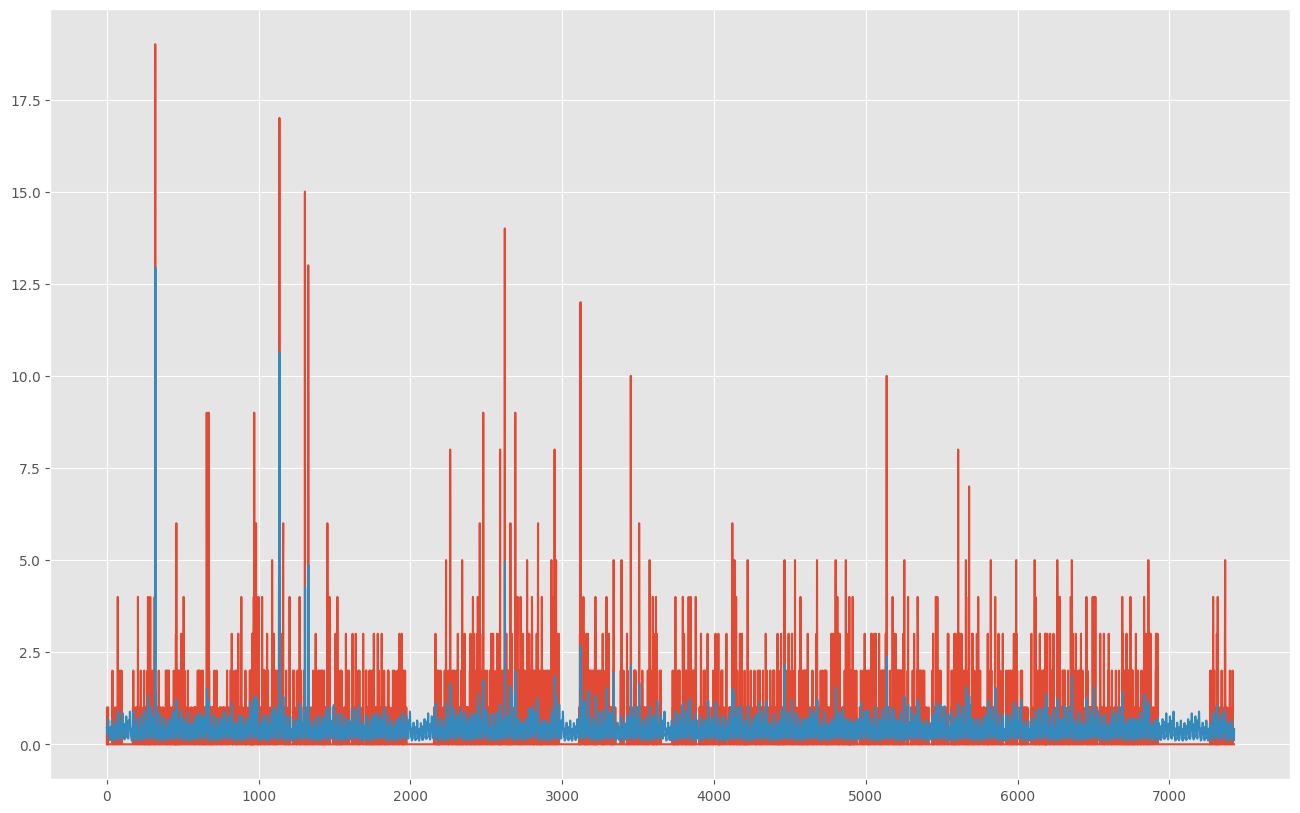

In [47]:
y_hat_train = np.mean(np.exp(alpha_samples.T + np.dot(X_train, beta_samples[:,0].T)), axis=1)
plt.plot(y_train)
plt.plot(y_hat_train)

# EXPERIMENT: Try modelling without flat periods (most likely largerly due to missing data)

In [55]:
df = merged_weather_df.copy()

# Initialize the new column with zeros
df['count_zeros_until_non_zero'] = 0

# Variable to store the count of consecutive zeros
count = 0

# Iterate through the DataFrame in reverse order using iloc
for i in range(len(df) - 1, -1, -1):
    if df.iloc[i]['accident_count'] == 0:
        count += 1
    else:
        count = 0
    df.iloc[i, df.columns.get_loc('count_zeros_until_non_zero')] = count

# Identify indices to drop
indices_to_drop = set()
for i in range(len(df)):
    if df.iloc[i]['count_zeros_until_non_zero'] > 150:
        for j in range(i + 1, i + 1 + df.iloc[i]['count_zeros_until_non_zero']):
            if j < len(df):
                indices_to_drop.add(j)

# Drop the identified indices
df_filtered = df.drop(indices_to_drop).reset_index(drop=True)

print("Original DataFrame:")
print(df)
print("\nFiltered DataFrame:")
print(df_filtered)

Original DataFrame:
                     hour geohash5  accident_count  hour_of_day  day_of_week  \
5     2022-01-01 05:00:00    9q5cw             0.0            5            5   
6     2022-01-01 06:00:00    9q5cw             1.0            6            5   
7     2022-01-01 07:00:00    9q5cw             0.0            7            5   
8     2022-01-01 08:00:00    9q5cw             0.0            8            5   
9     2022-01-01 09:00:00    9q5cw             0.0            9            5   
...                   ...      ...             ...          ...          ...   
8755  2022-12-31 19:00:00    9q5cw             4.0           19            5   
8756  2022-12-31 20:00:00    9q5cw             3.0           20            5   
8757  2022-12-31 21:00:00    9q5cw             0.0           21            5   
8758  2022-12-31 22:00:00    9q5cw             7.0           22            5   
8759  2022-12-31 23:00:00    9q5cw             0.0           23            5   

      hour_0  hour_

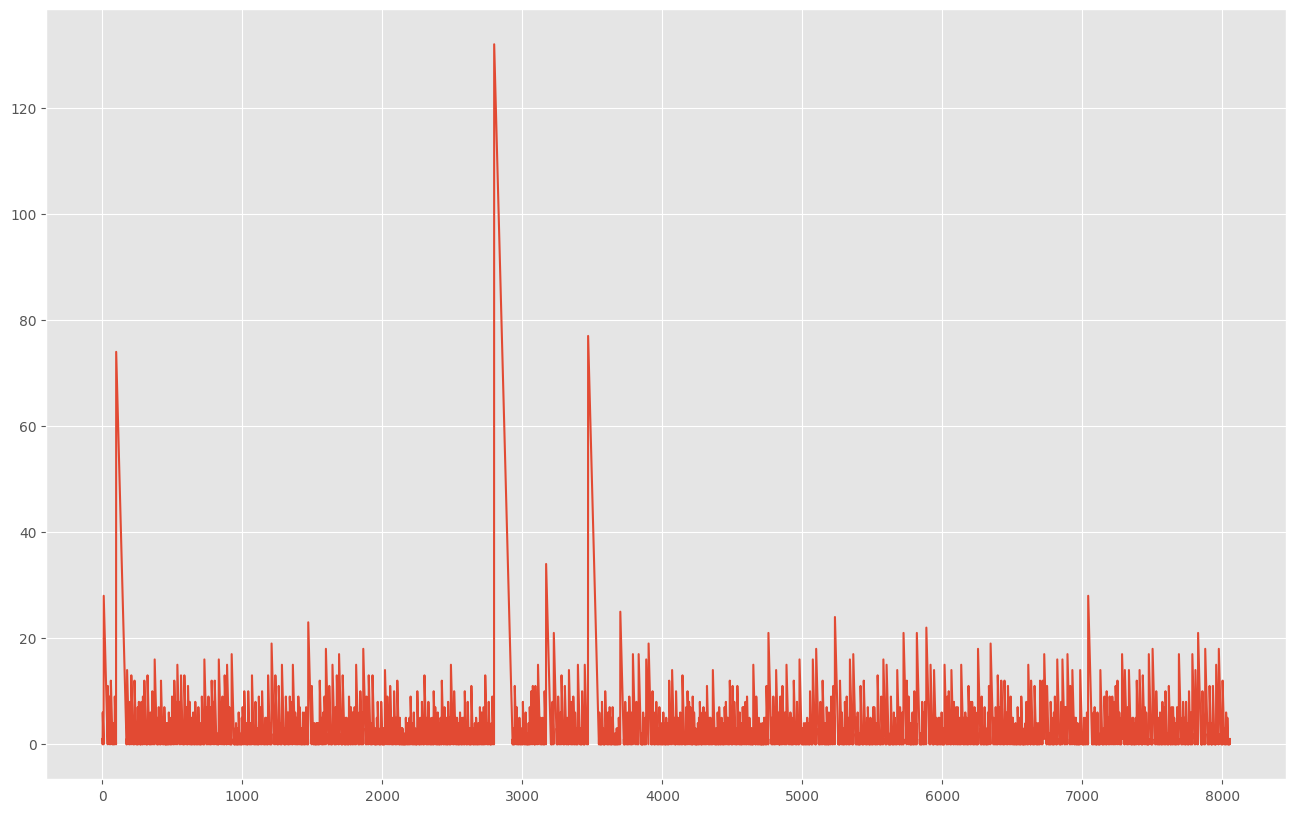

In [57]:
plt.plot(df_filtered['count_zeros_until_non_zero'])

In [58]:
# Features
features = merged_weather_df.drop(columns=['hour', 'geohash5', 'accident_count', 'hour_of_day', 'day_of_week']).columns

# Define target
y = np.array(df_filtered['accident_count'], dtype=np.float16)
X = np.array(df_filtered[features], dtype=np.float16)

# Split into train and test
N = len(X)
split_idx = int(0.85*N)
X_train = X[:split_idx,:]
y_train = y[:split_idx]
X_test = X[split_idx:,:]
y_test = y[split_idx:]

print(' X_train:', X_train.shape, '\n', 'X_test:', X_test.shape, '\n', 'y_train:', y_train.shape, '\n', 'y_test:', y_test.shape)

 X_train: (6845, 41) 
 X_test: (1208, 41) 
 y_train: (6845,) 
 y_test: (1208,)


In [59]:
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_test_mean = X_test.mean(axis=0)

X_train_std = X_train.std(axis=0)
X_test_std = X_test.std(axis=0)

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_test_mean) / X_test_std

c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [60]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [61]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [62]:
def poisson_model(X, obs=None):
    # alpha_hyper = pyro.sample("alpha_hyper", dist.HalfCauchy(5.))
    # beta_hyper = pyro.sample("beta_hyper", dist.HalfCauchy(5.))
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1]) * 0.25).to_event())    # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Poisson(torch.exp(alpha + X.matmul(beta))), obs=obs)
        
    return y

In [63]:
# Define guide function
guide = AutoDiagonalNormal(poisson_model)

# Reset parameter values
pyro.clear_param_store()

In [64]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(poisson_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 10342.2
[500] ELBO: 7276.9
[1000] ELBO: 6462.1
[1500] ELBO: 6317.1
[2000] ELBO: 6288.8
[2500] ELBO: 6285.0
[3000] ELBO: 6289.7
[3500] ELBO: 6280.1
[4000] ELBO: 6302.5
[4500] ELBO: 6275.9
[5000] ELBO: 6277.1
[5500] ELBO: 6276.0
[6000] ELBO: 6278.8
[6500] ELBO: 6276.9
[7000] ELBO: 6273.8
[7500] ELBO: 6276.4
[8000] ELBO: 6274.0
[8500] ELBO: 6275.2
[9000] ELBO: 6275.6
[9500] ELBO: 6277.8


In [65]:
predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [66]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()

y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T)), axis=1)

preds = y_hat 

corr, mae, rae, rmse, r2 = compute_error(y_test, preds)

print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.219
MAE: 0.611
RMSE: 0.918
R2: 0.042


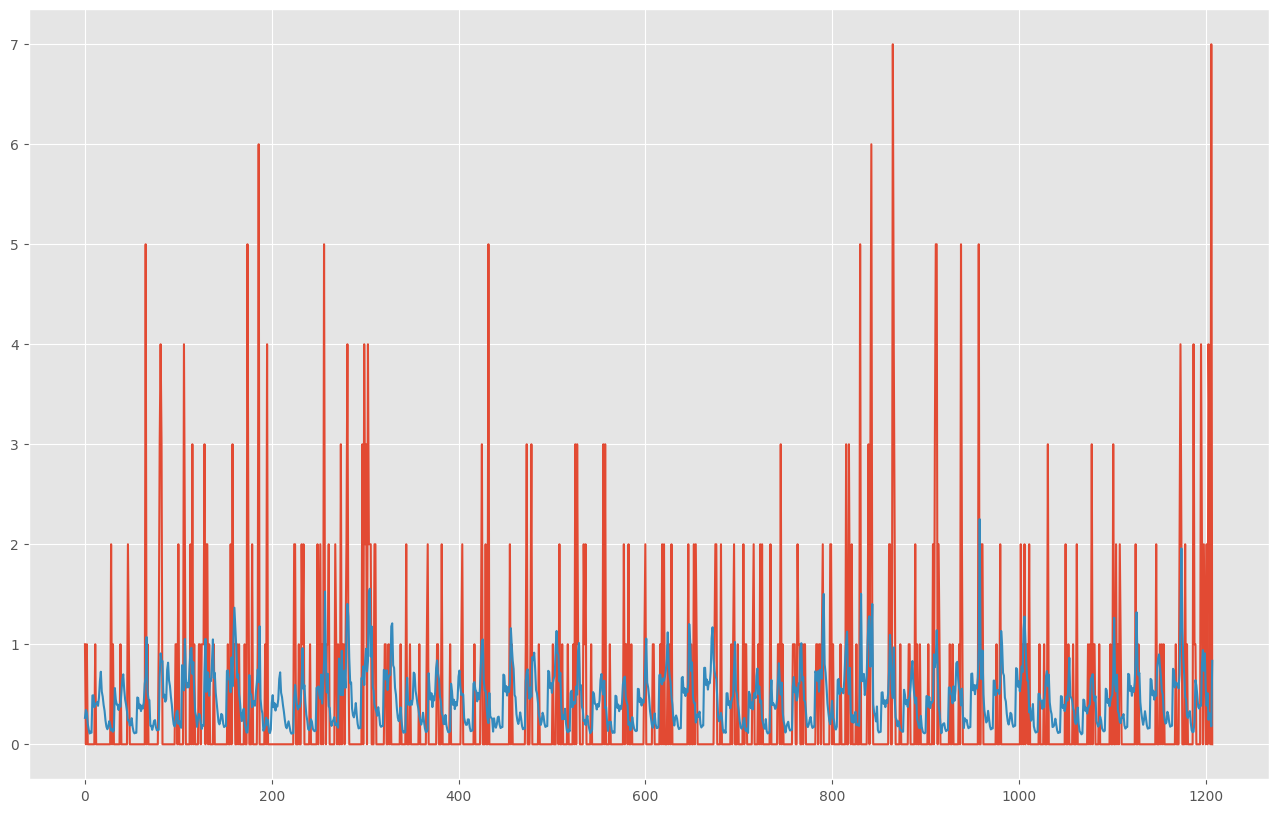

In [67]:
plt.plot(y_test)
plt.plot(preds)

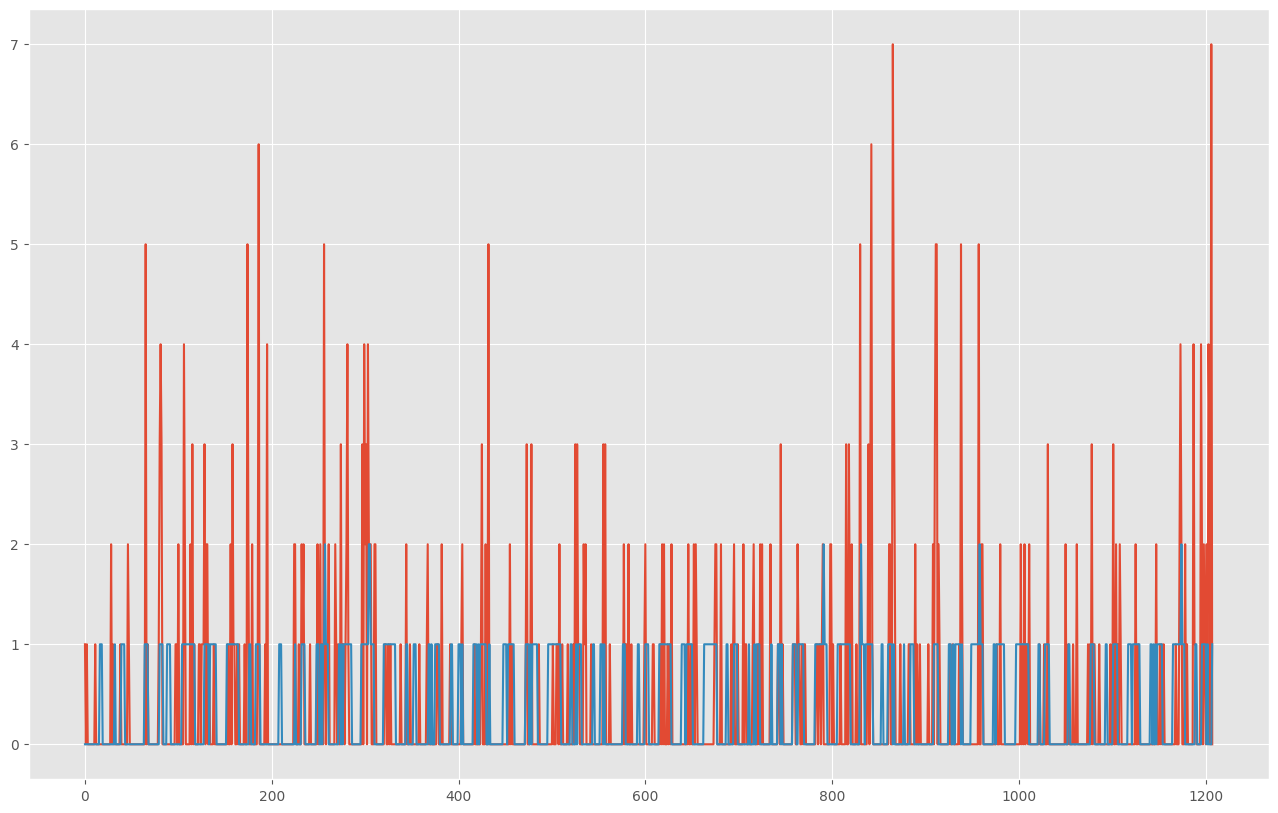

In [68]:
plt.plot(y_test)
plt.plot(np.round(preds, decimals=0))

(array([  3., 304., 697., 115.,  57.,  15.,  10.,   5.,   0.,   2.]),
 array([-2.        , -1.10000002, -0.2       ,  0.69999999,  1.60000002,
         2.5       ,  3.4000001 ,  4.30000019,  5.19999981,  6.0999999 ,
         7.        ]),
 <BarContainer object of 10 artists>)

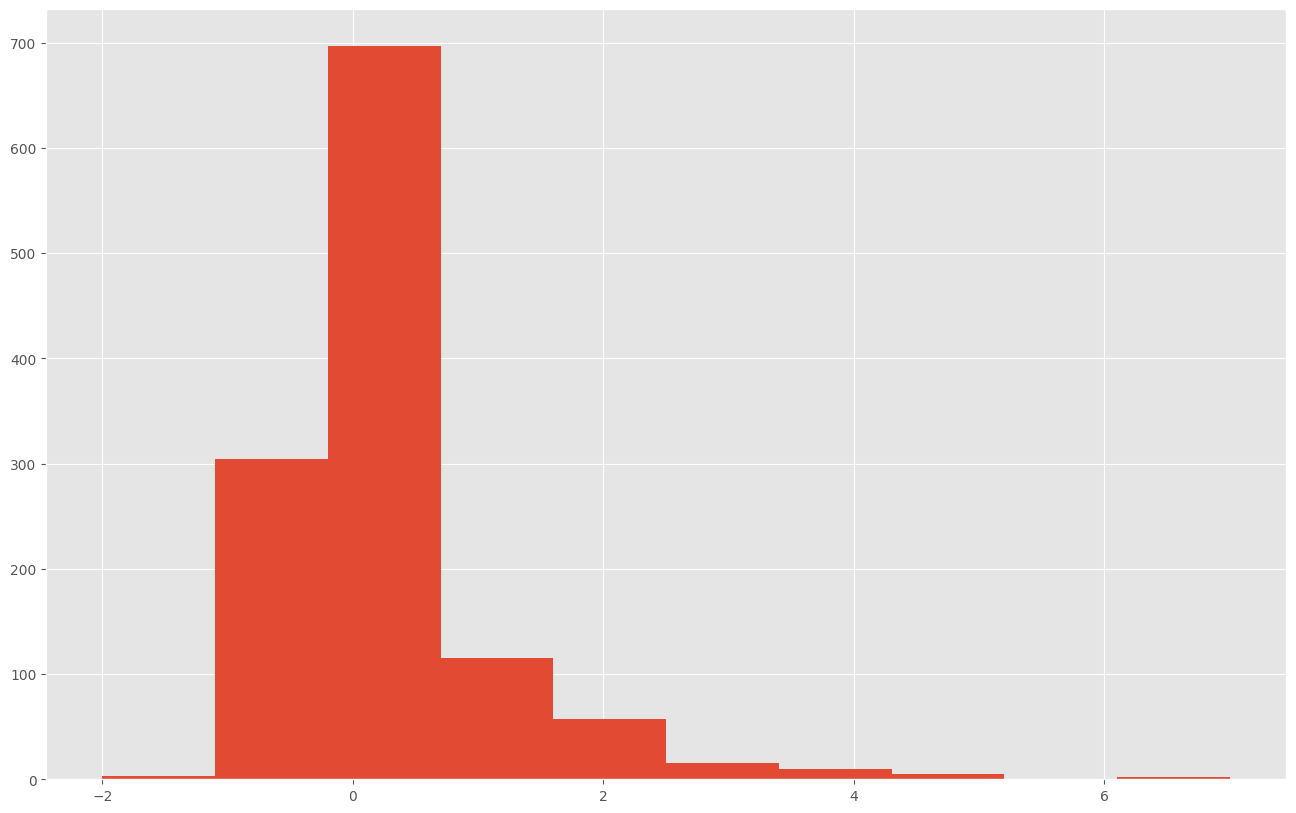

In [69]:
plt.hist(y_test - np.round(preds, decimals=0))